In [21]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Load the dataset (the same dataset you used for the teacher model)
def load_data(image_dir):
    images, labels = [], []
    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                if img_name.lower().endswith(('.jpeg', '.jpg', '.png')):
                    images.append(os.path.join(folder_path, img_name))
                    labels.append(folder_name)  # Class label
    print(f"Total images found: {len(images)}")
    print(f"Classes found: {set(labels)}")
    return images, labels

# Load the images and labels
IMAGE_DIR = r'C:\Users\shant\Downloads\DR images\colored_images\colored_images'  # Replace with your directory
images, labels = load_data(IMAGE_DIR)

# Split dataset into training and testing
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)







Total images found: 35126
Classes found: {'No_DR', 'Proliferate_DR', 'Moderate', 'Mild', 'Severe'}


In [4]:
# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Preprocessing function with batch tracking
def preprocess_images_in_batches(image_paths, batch_size=1000):
    total_images = len(image_paths)
    images = []
    
    for i in range(0, total_images, batch_size):
        batch_paths = image_paths[i:i + batch_size]
        
        # Process the current batch
        batch_images = []
        for path in batch_paths:
            img = load_img(path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0  # Normalize
            batch_images.append(img_array)
        
        images.extend(batch_images)
        
        # Print progress for every 1000 images processed
        if (i + batch_size) % 1000 == 0:
            print(f"Processed {min(i + batch_size, total_images)} / {total_images} images")

    return np.array(images)

# Preprocess train and test images in batches of 1000
train_images = preprocess_images_in_batches(train_images)
test_images = preprocess_images_in_batches(test_images)


Processed 1000 / 28100 images
Processed 2000 / 28100 images
Processed 3000 / 28100 images
Processed 4000 / 28100 images
Processed 5000 / 28100 images
Processed 6000 / 28100 images
Processed 7000 / 28100 images
Processed 8000 / 28100 images
Processed 9000 / 28100 images
Processed 10000 / 28100 images
Processed 11000 / 28100 images
Processed 12000 / 28100 images
Processed 13000 / 28100 images
Processed 14000 / 28100 images
Processed 15000 / 28100 images
Processed 16000 / 28100 images
Processed 17000 / 28100 images
Processed 18000 / 28100 images
Processed 19000 / 28100 images
Processed 20000 / 28100 images
Processed 21000 / 28100 images
Processed 22000 / 28100 images
Processed 23000 / 28100 images
Processed 24000 / 28100 images
Processed 25000 / 28100 images
Processed 26000 / 28100 images
Processed 27000 / 28100 images
Processed 28000 / 28100 images
Processed 28100 / 28100 images
Processed 1000 / 7026 images
Processed 2000 / 7026 images
Processed 3000 / 7026 images
Processed 4000 / 7026 i

In [23]:
# Define the Student Model
def create_student_model(num_classes):
    base_model = MobileNetV2(weights=None, include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True  # We want the student model to learn from the teacher

    for layer in base_model.layers[:50]:
        layer.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    output = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Load Teacher Model
teacher_model = load_model('teacher_model_mobilenetv2.h5')

In [29]:
# Initialize the Student Model
num_classes = len(np.unique(train_labels))
student_model = create_student_model(num_classes)

# Transfer knowledge from the Teacher Model to the Student Model
student_model.set_weights(teacher_model.get_weights())

# Train the student model with client data
def train_student_on_client_data(client_data, student_model, num_epochs=1):
    train_images, train_labels = client_data
    student_model.fit(train_images, train_labels, epochs=num_epochs, batch_size=32)

# Simulate splitting dataset into 4 clients
clients_data = []
num_clients = 4
split_size = len(train_images) // num_clients
for i in range(num_clients):
    client_images = train_images[i * split_size: (i + 1) * split_size]
    client_labels = train_labels[i * split_size: (i + 1) * split_size]
    clients_data.append((client_images, client_labels))

from tensorflow.keras.utils import to_categorical

# Convert train_labels and test_labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

# Update the federated learning process to use the one-hot encoded labels
def train_student_on_client_data(client_data, student_model, num_epochs=1):
    train_images, train_labels = client_data
    
    # Convert labels to one-hot encoding
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    
    student_model.fit(train_images, train_labels, epochs=num_epochs, batch_size=32)

# Federated Learning Round: Train Student Model using 4 Clients
import numpy as np

import numpy as np

def federated_learning_round_with_teacher(clients, student_model, num_epochs=1):
    client_weights = []
    
    for client_data in clients:
        # Initialize a new student model for each client with teacher's weights
        client_model = create_student_model(num_classes)
        client_model.set_weights(student_model.get_weights())  # Initialize with student model's weights
        
        # Train on client's local data
        train_student_on_client_data(client_data, client_model, num_epochs)
        
        # Store flattened client model weights after local training
        flattened_weights = np.concatenate([w.flatten() for w in client_model.get_weights()])
        client_weights.append(flattened_weights)
        
        # Print the flattened weights shape to debug
        print(f"Flattened client model weights shape: {flattened_weights.shape}")
    
    # Check that all client weights are the same shape before averaging
    weights_shapes = [weights.shape for weights in client_weights]
    if len(set(weights_shapes)) > 1:
        print("Inconsistent weights shapes detected!")
        print("Shapes:", weights_shapes)
    
    # Aggregate the model weights (average them)
    global_weights = np.mean(client_weights, axis=0)
    
    # Reshape the global weights back to the original shape of the model
    start = 0
    new_weights = []
    for weight in student_model.get_weights():
        size = np.prod(weight.shape)  # Number of elements in the weight matrix
        new_weights.append(global_weights[start:start + size].reshape(weight.shape))
        start += size
    
    # Update the student model with the new aggregated weights
    student_model.set_weights(new_weights)

    return student_model


# Federated learning rounds
num_rounds = 10
for round_num in range(num_rounds):
    print(f"Starting round {round_num + 1}/{num_rounds}")
    student_model = federated_learning_round_with_teacher(clients_data, student_model)

Starting round 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 166s 674ms/step - accuracy: 0.7976 - loss: 0.6921
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 176s 724ms/step - accuracy: 0.8028 - loss: 0.6638
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 161s 667ms/step - accuracy: 0.8092 - loss: 0.6403
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 164s 668ms/step - accuracy: 0.8050 - loss: 0.6307
Flattened client model weights shape: (2422597,)
Starting round 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 157s 651ms/step - accuracy: 0.9063 - loss: 0.2602
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 173s 707ms/step - accuracy: 0.9034 - loss: 0.2684
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 168s 701ms/step - accuracy: 0.8972 - loss: 0.2769
Flattened client model weights shape: (2422597,)
220/220 ━━━━━━━━━━━━━━━━━━━━ 186s 767ms/step - accuracy: 0.9053 

In [42]:
# Save the student model
student_model.save("student_model_mobilenetv2.h5")

In [44]:
print("Training the student model...")
print(student_model.summary())


Training the student model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 2,339,205 (8.92 MB)

 Non-trainable params: 83,392 (325.75 KB)

None


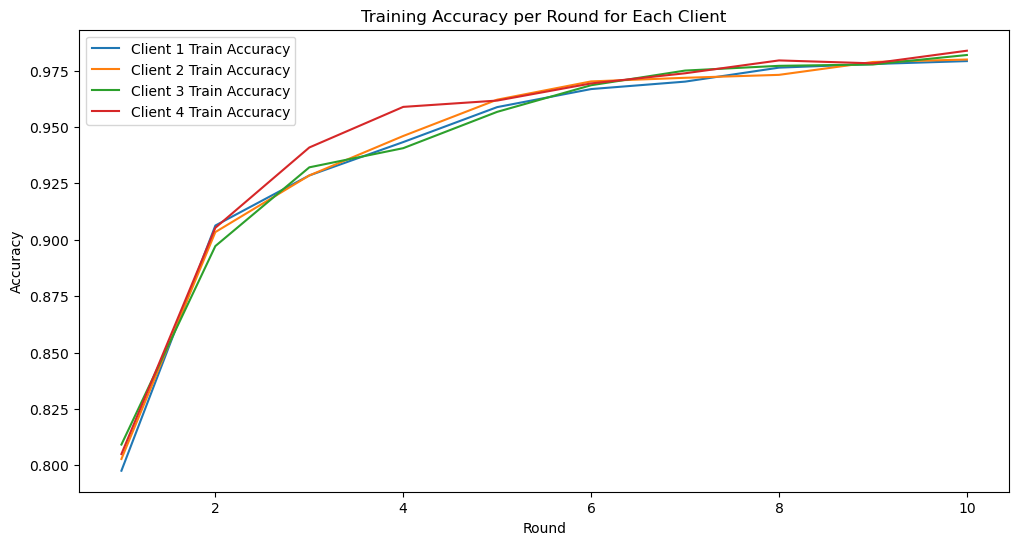

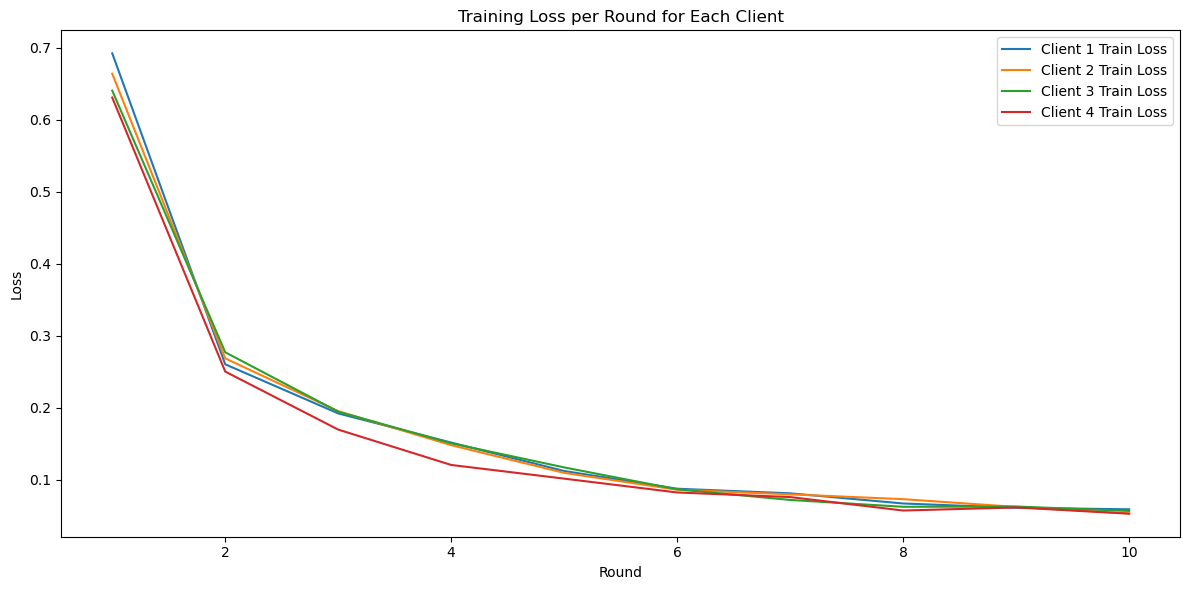

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Manually extracted accuracy and loss values
train_accuracies = [
    [0.7976, 0.8028, 0.8092, 0.8050],
    [0.9063, 0.9034, 0.8972, 0.9053],
    [0.9285, 0.9285, 0.9321, 0.9409],
    [0.9433, 0.9460, 0.9406, 0.9589],
    [0.9588, 0.9621, 0.9567, 0.9617],
    [0.9668, 0.9702, 0.9685, 0.9693],
    [0.9701, 0.9718, 0.9750, 0.9738],
    [0.9763, 0.9731, 0.9771, 0.9795],
    [0.9779, 0.9788, 0.9777, 0.9782],
    [0.9792, 0.9799, 0.9819, 0.9838]
]

train_losses = [
    [0.6921, 0.6638, 0.6403, 0.6307],
    [0.2602, 0.2684, 0.2769, 0.2501],
    [0.1920, 0.1951, 0.1944, 0.1695],
    [0.1515, 0.1479, 0.1505, 0.1204],
    [0.1120, 0.1094, 0.1170, 0.1014],
    [0.0874, 0.0860, 0.0866, 0.0822],
    [0.0810, 0.0796, 0.0718, 0.0758],
    [0.0669, 0.0729, 0.0623, 0.0571],
    [0.0609, 0.0621, 0.0627, 0.0614],
    [0.0588, 0.0532, 0.0565, 0.0527]
]

# Create the rounds array
rounds = np.arange(1, 11)

# Plot Training Accuracy
plt.figure(figsize=(12, 6))
for i in range(len(train_accuracies[0])):  # 4 clients
    plt.plot(rounds, [train_accuracies[r][i] for r in range(10)], label=f'Client {i+1} Train Accuracy')

plt.title('Training Accuracy per Round for Each Client')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.figure(figsize=(12, 6))
for i in range(len(train_losses[0])):  # 4 clients
    plt.plot(rounds, [train_losses[r][i] for r in range(10)], label=f'Client {i+1} Train Loss')

plt.title('Training Loss per Round for Each Client')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Function to predict in batches
def predict_in_batches(model, images, batch_size=32):
    # Create an empty list to store predictions
    predictions = []
    
    # Iterate over the data in batches
    for i in range(0, len(images), batch_size):
        batch_images = images[i:i+batch_size]
        batch_predictions = model.predict(batch_images, batch_size=batch_size)
        predictions.append(batch_predictions)
    
    # Concatenate all predictions into a single array
    return np.concatenate(predictions, axis=0)

# Predict in batches
predictions = predict_in_batches(student_model, test_images, batch_size=32)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute accuracy (just the mean of correct predictions)
accuracy = np.mean(predicted_labels == np.argmax(test_labels_onehot, axis=1))
print(f"Final Student Model Accuracy: {accuracy:.4f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(np.argmax(test_labels_onehot, axis=1), predicted_labels)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

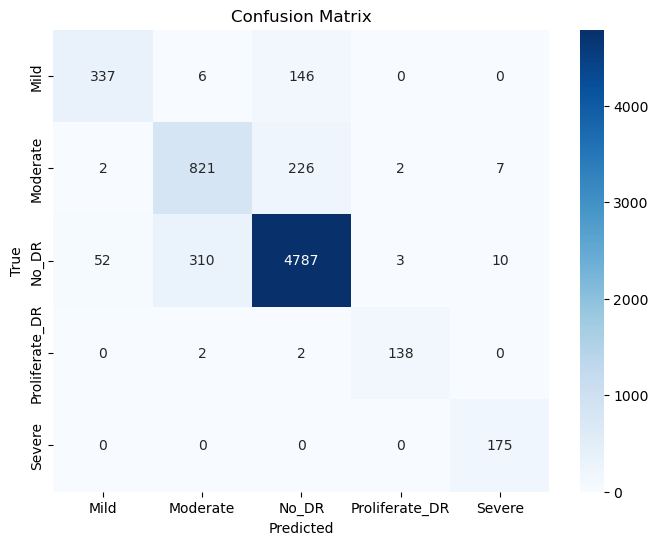


Classification Report:

                precision    recall  f1-score   support

          Mild       0.86      0.69      0.77       489
      Moderate       0.72      0.78      0.75      1058
         No_DR       0.93      0.93      0.93      5162
Proliferate_DR       0.97      0.97      0.97       142
        Severe       0.91      1.00      0.95       175

      accuracy                           0.89      7026
     macro avg       0.88      0.87      0.87      7026
  weighted avg       0.89      0.89      0.89      7026



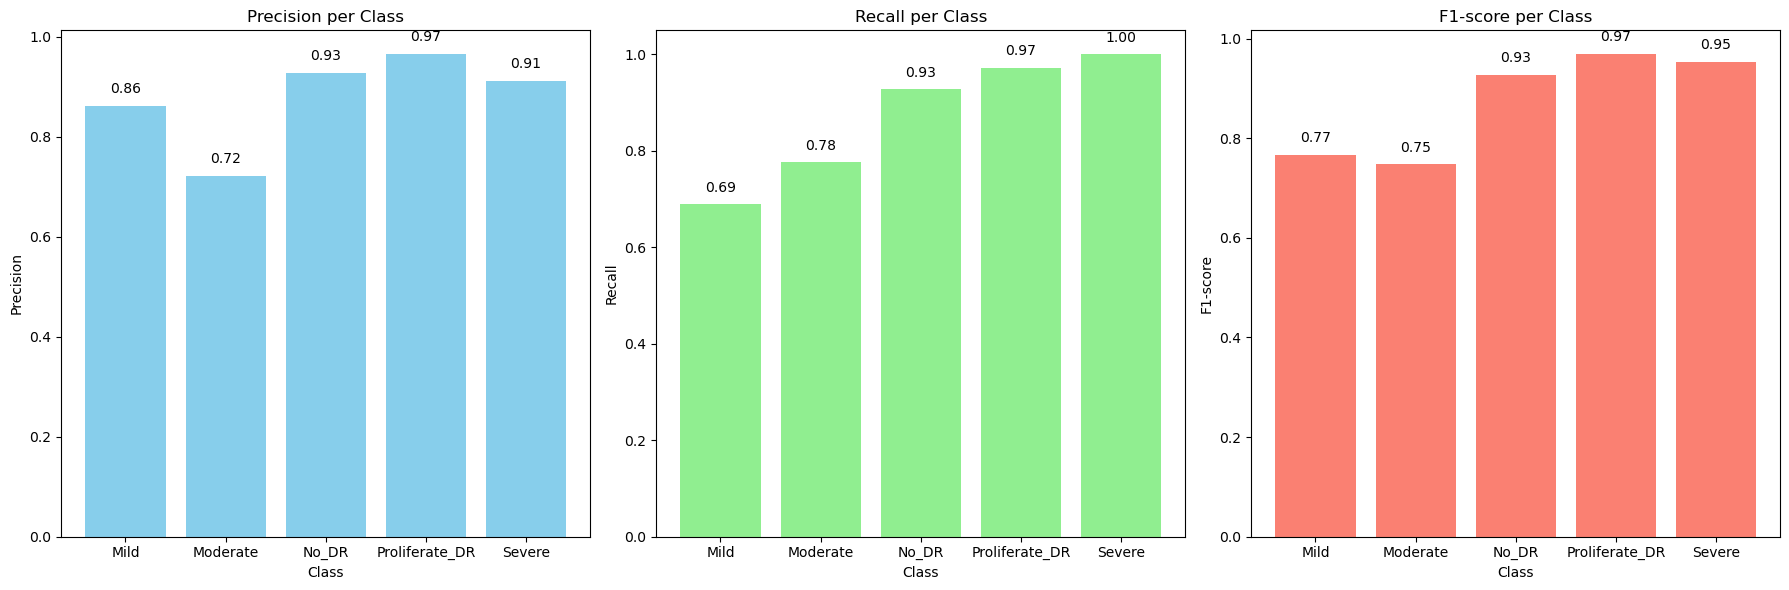

In [141]:
# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Optional: Print classification report for more detailed metrics (precision, recall, f1-score)
print("\nClassification Report:\n")
report = classification_report(np.argmax(test_labels_onehot, axis=1), predicted_labels, target_names=label_encoder.classes_)
print(report)

# Convert classification report to a dictionary
report_dict = classification_report(np.argmax(test_labels_onehot, axis=1), predicted_labels, target_names=label_encoder.classes_, output_dict=True)

# Extract precision, recall, and f1-score for plotting
labels = list(report_dict.keys())[:-3]  # Remove 'accuracy', 'macro avg', and 'weighted avg'
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

# Plot precision, recall, and F1-score as bar plots
# Plot precision, recall, and F1-score as vertical bar plots with numbers
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Precision Plot (vertical bars)
ax[0].bar(labels, precision, color='skyblue')
ax[0].set_title('Precision per Class')
ax[0].set_ylabel('Precision')
ax[0].set_xlabel('Class')

# Add numbers above each bar in the precision plot
for i, v in enumerate(precision):
    ax[0].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# Recall Plot (vertical bars)
ax[1].bar(labels, recall, color='lightgreen')
ax[1].set_title('Recall per Class')
ax[1].set_ylabel('Recall')
ax[1].set_xlabel('Class')

# Add numbers above each bar in the recall plot
for i, v in enumerate(recall):
    ax[1].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

# F1-score Plot (vertical bars)
ax[2].bar(labels, f1_score, color='salmon')
ax[2].set_title('F1-score per Class')
ax[2].set_ylabel('F1-score')
ax[2].set_xlabel('Class')

# Add numbers above each bar in the F1-score plot
for i, v in enumerate(f1_score):
    ax[2].text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
